In [2]:
# Setup (paths, imports, seeds)

import os, json, random, sys, platform
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Project paths (adjust PROJ if you keep a fixed location)
PROJ = Path.cwd()  # or Path(r"C:\Users\nikhi\Music\ECG")
PREPARED = PROJ / "prepared"
RESULTS  = PROJ / "results"
MODELS   = PROJ / "models"

for p in [PREPARED, RESULTS, MODELS]:
    p.mkdir(parents=True, exist_ok=True)

print("Python:", sys.version)
print("TF:", tf.__version__)
print("Project dir:", PROJ)


Python: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
TF: 2.20.0
Project dir: C:\Users\nikhi\Music\ECG


In [3]:
# Load prepared arrays

def npy(path):
    if path.exists():
        return np.load(path)
    else:
        raise FileNotFoundError(f"Missing file: {path}")

X_train_path = PREPARED / "X_train_balanced_dl.npy"
X_val_path   = PREPARED / "X_val_dl.npy"
X_test_path  = PREPARED / "X_test_dl.npy"
y_train_path = PREPARED / "y_train_balanced.npy"
y_val_path   = PREPARED / "y_val.npy"
y_test_path  = PREPARED / "y_test.npy"

X_train = npy(X_train_path);  y_train = npy(y_train_path)
X_val   = npy(X_val_path);    y_val   = npy(y_val_path)
X_test  = npy(X_test_path);   y_test  = npy(y_test_path)

INPUT_LEN  = X_train.shape[1]
CHANNELS   = X_train.shape[2] if X_train.ndim == 3 else 1
NUM_CLASSES= int(np.max([y_train.max(), y_val.max(), y_test.max()])) + 1

print("Shapes:", X_train.shape, X_val.shape, X_test.shape, "| classes:", NUM_CLASSES)


Shapes: (80032, 187, 1) (8756, 187, 1) (21892, 187, 1) | classes: 5


In [4]:
# Class weights (load from earlier, else compute from y_train)

from collections import Counter

cw_file = PREPARED / "class_weight.json"
if cw_file.exists():
    class_weight = {int(k): float(v) for k, v in json.load(open(cw_file)).items()}
    print("Loaded class_weight from:", cw_file)
else:
    cnt = Counter(y_train.tolist())
    total = sum(cnt.values())
    class_weight = {c: total/(NUM_CLASSES*cnt[c]) for c in range(NUM_CLASSES)}
    print("Computed class_weight from y_train.")

print("class_weight:", class_weight)


Loaded class_weight from: C:\Users\nikhi\Music\ECG\prepared\class_weight.json
class_weight: {0: 0.24541036137558836, 1: 7.9992003998001, 2: 3.0728354770589363, 3: 8.838431805632247, 4: 2.765445749827229}


In [5]:
# tf.data pipelines (light time-shift + jitter) and static shapes

BATCH_SIZE = 256
AUTOTUNE   = tf.data.AUTOTUNE

@tf.function
def aug_timeshift(x, max_shift=3):
    s = tf.random.uniform([], minval=-max_shift, maxval=max_shift+1, dtype=tf.int32)
    return tf.roll(x, shift=s, axis=0)

@tf.function
def aug_jitter(x, sigma=0.01):
    noise = tf.random.normal(tf.shape(x), stddev=sigma, dtype=x.dtype)
    return x + noise

def train_map_fn(x, y):
    x = tf.squeeze(x, -1)            # (187,)
    x = tf.cond(tf.random.uniform([]) < 0.5, lambda: aug_timeshift(x), lambda: x)
    x = tf.cond(tf.random.uniform([]) < 0.5, lambda: aug_jitter(x),   lambda: x)
    x = tf.expand_dims(x, -1)        # (187,1)
    x = tf.cast(x, tf.float32)
    x.set_shape([INPUT_LEN, CHANNELS])
    return x, y

def eval_map_fn(x, y):
    x = tf.cast(x, tf.float32)
    x.set_shape([INPUT_LEN, CHANNELS])
    return x, y

def make_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(min(len(y), 20000), seed=SEED, reshuffle_each_iteration=True)
        ds = ds.map(train_map_fn, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(eval_map_fn, num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

ds_train = make_ds(X_train, y_train, training=True)
ds_val   = make_ds(X_val,   y_val,   training=False)
ds_test  = make_ds(X_test,  y_test,  training=False)

ds_train, ds_val


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 187, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 187, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [6]:
# CNN feature extractor blocks

from tensorflow.keras import layers

def conv_block(x, filters, kernel, stride=1, name=None):
    x = layers.Conv1D(filters, kernel, strides=stride, padding="same",
                      use_bias=False, name=None if not name else name+"_conv")(x)
    x = layers.BatchNormalization(name=None if not name else name+"_bn")(x)
    x = layers.Activation("relu", name=None if not name else name+"_relu")(x)
    return x


In [7]:
# Build CNN + BiLSTM hybrid (Avg+Max temporal pooling)

from tensorflow.keras import Model, layers

def build_cnn_bilstm(input_len=187, channels=1, n_classes=5,
                     base=48, lstm_units=64, dropout=0.15, head_dropout=0.20):
    inp = layers.Input(shape=(input_len, channels))

    # CNN stem: mild downsampling
    x = conv_block(inp, base,   15, stride=1, name="c1")
    x = conv_block(x,  base,     7, stride=2, name="c1_down")    # /2

    x = conv_block(x,  base*2,   7, stride=1, name="c2")
    x = conv_block(x,  base*2,   5, stride=2, name="c2_down")    # /2

    x = conv_block(x,  base*4,   3, stride=1, name="c3")
    x = layers.Dropout(dropout, name="cnn_dropout")(x)

    # BiLSTM head (temporal modeling)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True), name="bilstm")(x)

    # Temporal pooling : Avg + Max → concat
    x_avg = layers.GlobalAveragePooling1D(name="tgap")(x)
    x_max = layers.GlobalMaxPooling1D(name="tgmp")(x)
    x = layers.Concatenate(name="tpool_concat")([x_avg, x_max])

    # Small head
    x = layers.Dropout(head_dropout, name="head_dropout")(x)
    out = layers.Dense(n_classes, activation="softmax", dtype="float32", name="output")(x)

    return Model(inp, out, name="CNN_BiLSTM_Hybrid")

model = build_cnn_bilstm(INPUT_LEN, CHANNELS, NUM_CLASSES,
                         base=48, lstm_units=64, dropout=0.15, head_dropout=0.20)
model.summary()


Model: "CNN_BiLSTM_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 187, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c1_conv (Conv1D)              │ (None, 187, 48)           │             720 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c1_bn (BatchNormalization)    │ (None, 187, 48)           │             192 │ c1_conv[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c1_relu (Activation)          │ (None, 187, 48)           │               0 │ c1_bn[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c1_down_conv (Conv1D)         │ (None, 94, 48)            │          16,128 │ c1_relu[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c1_down_bn                    │ (None, 94, 48)            │             192 │ c1_down_conv[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c1_down_relu (Activation)     │ (None, 94, 48)            │               0 │ c1_down_bn[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c2_conv (Conv1D)              │ (None, 94, 96)            │          32,256 │ c1_down_relu[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c2_bn (BatchNormalization)    │ (None, 94, 96)            │             384 │ c2_conv[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c2_relu (Activation)          │ (None, 94, 96)            │               0 │ c2_bn[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c2_down_conv (Conv1D)         │ (None, 47, 96)            │          46,080 │ c2_relu[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c2_down_bn                    │ (None, 47, 96)            │             384 │ c2_down_conv[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c2_down_relu (Activation)     │ (None, 47, 96)            │               0 │ c2_down_bn[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c3_conv (Conv1D)              │ (None, 47, 192)           │          55,296 │ c2_down_relu[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c3_bn (BatchNormalization)    │ (None, 47, 192)           │             768 │ c3_conv[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c3_relu (Activation)          │ (None, 47, 192)           │               0 │ c3_bn[0][0]                │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 285,269 (1.09 MB)

 Trainable params: 284,309 (1.08 MB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
# Compile + callbacks

from tensorflow import keras

LR = 1e-3
model.compile(
    optimizer=keras.optimizers.Adam(LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

ckpt = MODELS / "ecg_cnn_bilstm_best.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt.as_posix(), monitor="val_acc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=10, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1),
]
print("Checkpoint:", ckpt)


Checkpoint: C:\Users\nikhi\Music\ECG\models\ecg_cnn_bilstm_best.keras


In [9]:
# Cell 8: Train CNN + BiLSTM

EPOCHS = 60
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    class_weight=class_weight,   # imbalance-aware
    callbacks=callbacks,
    verbose=1
)


Epoch 1/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - acc: 0.6245 - loss: 0.7436
Epoch 1: val_acc improved from None to 0.29454, saving model to C:/Users/nikhi/Music/ECG/models/ecg_cnn_bilstm_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 264ms/step - acc: 0.7334 - loss: 0.5425 - val_acc: 0.2945 - val_loss: 2.0143 - learning_rate: 0.0010
Epoch 2/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - acc: 0.8226 - loss: 0.3702
Epoch 2: val_acc improved from 0.29454 to 0.93776, saving model to C:/Users/nikhi/Music/ECG/models/ecg_cnn_bilstm_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 96s 306ms/step - acc: 0.8353 - loss: 0.3470 - val_acc: 0.9378 - val_loss: 0.2159 - learning_rate: 0.0010
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - acc: 0.8537 - loss: 0.2969
Epoch 3: val_acc did not improve from 0.93776
313/313 ━━━━━━━━━━━━━━━━━━━━ 150s 332ms/step - acc: 0.8598 - loss: 0.2838 - val_acc: 0.9370 - val_loss: 0.2197 - learning_rate: 0.0010
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step -

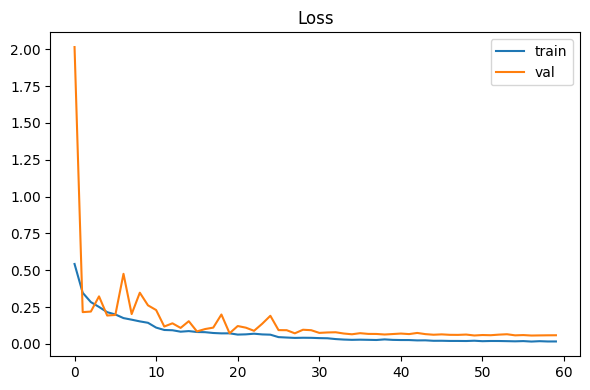

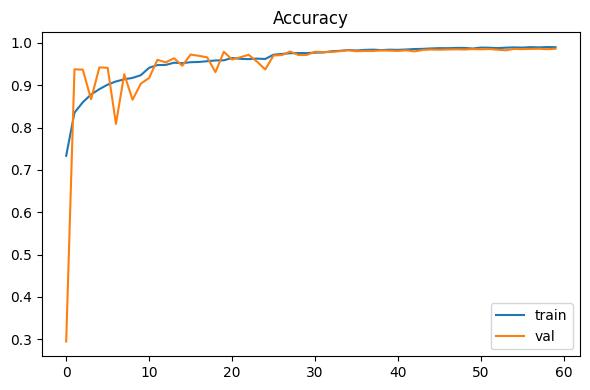

In [11]:
# Learning curves

hist = history.history
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(hist["loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.title("Loss"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["acc"], label="train")
plt.plot(hist["val_acc"], label="val")
plt.title("Accuracy"); plt.legend(); plt.tight_layout(); plt.show()


[VAL] macro-F1: 0.9248443501929948
              precision    recall  f1-score   support

           N     0.9965    0.9892    0.9929      7248
           S     0.8571    0.9189    0.8870       222
           V     0.9497    0.9775    0.9634       579
           F     0.7179    0.8750    0.7887        64
           Q     0.9877    0.9969    0.9923       643

    accuracy                         0.9864      8756
   macro avg     0.9018    0.9515    0.9248      8756
weighted avg     0.9872    0.9864    0.9867      8756



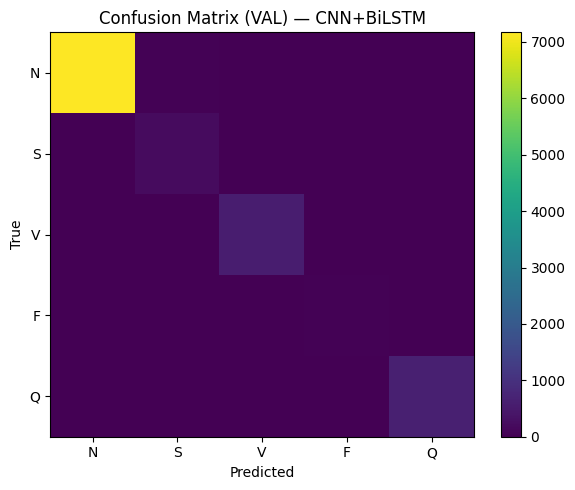

[VAL] PR-AUC(macro): 0.9580 | ROC-AUC(macro): 0.9971


In [12]:
# Validation evaluation (macro-F1 + per-class + CM)

import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

proba_val = model.predict(ds_val, verbose=0)
y_val_pred = proba_val.argmax(axis=1)

print("[VAL] macro-F1:", f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred, target_names=["N","S","V","F","Q"], digits=4))

cm_val = confusion_matrix(y_val, y_val_pred, labels=[0,1,2,3,4])
plt.figure(figsize=(6,5))
plt.imshow(cm_val, aspect='auto')
plt.title("Confusion Matrix (VAL) — CNN+BiLSTM")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(5), ["N","S","V","F","Q"]); plt.yticks(range(5), ["N","S","V","F","Q"])
plt.colorbar(); plt.tight_layout(); plt.show()

# Optional curve metrics
try:
    ap_macro = average_precision_score(y_val, proba_val, average="macro")
    roc_macro = roc_auc_score(y_val, proba_val, multi_class="ovr", average="macro")
    print(f"[VAL] PR-AUC(macro): {ap_macro:.4f} | ROC-AUC(macro): {roc_macro:.4f}")
except Exception as e:
    print("AUC computations skipped:", e)


[TEST] macro-F1: 0.9159023011494947
              precision    recall  f1-score   support

           N     0.9951    0.9890    0.9920     18118
           S     0.8099    0.8813    0.8441       556
           V     0.9499    0.9682    0.9590      1448
           F     0.7150    0.8827    0.7901       162
           Q     0.9956    0.9932    0.9944      1608

    accuracy                         0.9844     21892
   macro avg     0.8931    0.9429    0.9159     21892
weighted avg     0.9853    0.9844    0.9847     21892



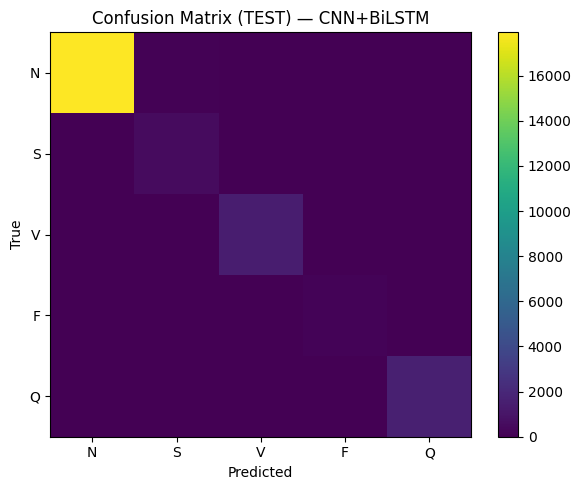

In [13]:
# Test evaluation

proba_test = model.predict(ds_test, verbose=0)
y_test_pred = proba_test.argmax(axis=1)

from sklearn.metrics import f1_score, classification_report, confusion_matrix
print("[TEST] macro-F1:", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred, target_names=["N","S","V","F","Q"], digits=4))

cm_test = confusion_matrix(y_test, y_test_pred, labels=[0,1,2,3,4])
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.imshow(cm_test, aspect='auto')
plt.title("Confusion Matrix (TEST) — CNN+BiLSTM")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(5), ["N","S","V","F","Q"]); plt.yticks(range(5), ["N","S","V","F","Q"])
plt.colorbar(); plt.tight_layout(); plt.show()


In [14]:
# Save artifacts for CNN+BiLSTM

# Save the last model; best already saved by checkpoint
model.save(MODELS / "ecg_cnn_bilstm_last.keras")

# Persist predictions
np.save(RESULTS / "cnn_bilstm_val_pred.npy",  y_val_pred)
np.save(RESULTS / "cnn_bilstm_test_pred.npy", y_test_pred)

# Save textual reports
from sklearn.metrics import classification_report
rep_val  = classification_report(y_val,  y_val_pred,  target_names=["N","S","V","F","Q"], digits=4)
rep_test = classification_report(y_test, y_test_pred, target_names=["N","S","V","F","Q"], digits=4)
open(RESULTS / "cnn_bilstm_report_val.txt", "w").write(rep_val)
open(RESULTS / "cnn_bilstm_report_test.txt","w").write(rep_test)

print("Saved CNN+BiLSTM artifacts to", RESULTS, "and", MODELS)


Saved CNN+BiLSTM artifacts to C:\Users\nikhi\Music\ECG\results and C:\Users\nikhi\Music\ECG\models


In [15]:
# Gentle focal fine-tune for CNN+BiLSTM

import numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

# Build alpha from class_weight and normalize
alpha_vec = np.array([class_weight[c] for c in range(5)], dtype=np.float32)
alpha_vec = alpha_vec / alpha_vec.mean()
GAMMA = 2.0

def sparse_categorical_focal_loss(alpha=None, gamma=2.0, eps=1e-7):
    alpha_t = None if alpha is None else tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        y_true_oh = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        pt = tf.reduce_sum(y_true_oh * y_pred, axis=-1)
        a = tf.reduce_sum(y_true_oh * alpha_t, axis=-1) if alpha_t is not None else 1.0
        return tf.reduce_mean(-a * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss_fn

# Load best BiLSTM
bilstm_best = MODELS / "ecg_cnn_bilstm_best.keras"
model_bilstm_ft = load_model(bilstm_best)
print("Loaded:", bilstm_best)

# Compile with focal; small LR
model_bilstm_ft.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=sparse_categorical_focal_loss(alpha=alpha_vec, gamma=GAMMA),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

bilstm_ft_ckpt = MODELS / "ecg_cnn_bilstm_focal_best.keras"
callbacks_ft = [
    keras.callbacks.ModelCheckpoint(bilstm_ft_ckpt.as_posix(), monitor="val_acc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=3, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]

history_bilstm_ft = model_bilstm_ft.fit(
    ds_train,
    validation_data=ds_val,
    epochs=6,            # short, gentle run
    class_weight=None,   # focal does the reweighting
    callbacks=callbacks_ft,
    verbose=1
)


Loaded: C:\Users\nikhi\Music\ECG\models\ecg_cnn_bilstm_best.keras
Epoch 1/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - acc: 0.9843 - loss: 0.0036
Epoch 1: val_acc improved from None to 0.98116, saving model to C:/Users/nikhi/Music/ECG/models/ecg_cnn_bilstm_focal_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 412ms/step - acc: 0.9814 - loss: 0.0039 - val_acc: 0.9812 - val_loss: 0.0229 - learning_rate: 3.0000e-04
Epoch 2/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - acc: 0.9762 - loss: 0.0045
Epoch 2: val_acc did not improve from 0.98116
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 392ms/step - acc: 0.9801 - loss: 0.0036 - val_acc: 0.9797 - val_loss: 0.0219 - learning_rate: 3.0000e-04
Epoch 3/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - acc: 0.9788 - loss: 0.0035
Epoch 3: val_acc did not improve from 0.98116
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 432ms/step - acc: 0.9798 - loss: 0.0034 - val_acc: 0.9760 - val_loss: 0.0233 - learning_rate: 3.0000e-04
Epoch 4/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/ste

In [16]:
# Compare pre/post focal fine-tune on VAL & TEST

from sklearn.metrics import f1_score, classification_report

# Pre-finetune (current)
proba_val_pre  = model.predict(ds_val,  verbose=0)
proba_test_pre = model.predict(ds_test, verbose=0)
y_val_pred_pre  = proba_val_pre.argmax(axis=1)
y_test_pred_pre = proba_test_pre.argmax(axis=1)

# Post-finetune
proba_val_post  = model_bilstm_ft.predict(ds_val,  verbose=0)
proba_test_post = model_bilstm_ft.predict(ds_test, verbose=0)
y_val_pred_post  = proba_val_post.argmax(axis=1)
y_test_pred_post = proba_test_post.argmax(axis=1)

print(f"[VAL]  macro-F1: pre={f1_score(y_val, y_val_pred_pre, average='macro'):.4f}  → post={f1_score(y_val, y_val_pred_post, average='macro'):.4f}")
print(f"[TEST] macro-F1: pre={f1_score(y_test, y_test_pred_pre, average='macro'):.4f} → post={f1_score(y_test, y_test_pred_post, average='macro'):.4f}")

print("\n[TEST] report (post-finetune):")
print(classification_report(y_test, y_test_pred_post, target_names=["N","S","V","F","Q"], digits=4))


[VAL]  macro-F1: pre=0.9248  → post=0.8963
[TEST] macro-F1: pre=0.9159 → post=0.8907

[TEST] report (post-finetune):
              precision    recall  f1-score   support

           N     0.9944    0.9813    0.9878     18118
           S     0.7101    0.8723    0.7829       556
           V     0.9345    0.9662    0.9501      1448
           F     0.6344    0.8889    0.7404       162
           Q     0.9931    0.9913    0.9922      1608

    accuracy                         0.9776     21892
   macro avg     0.8533    0.9400    0.8907     21892
weighted avg     0.9805    0.9776    0.9786     21892



In [17]:
# Revert to the best pre-finetune BiLSTM and save as final

from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np

bilstm_best = MODELS / "ecg_cnn_bilstm_best.keras"   
model_bilstm_final = load_model(bilstm_best)
print("Loaded pre-finetune BiLSTM:", bilstm_best)

# Re-evaluate on VAL/TEST
proba_val_final  = model_bilstm_final.predict(ds_val,  verbose=0)
proba_test_final = model_bilstm_final.predict(ds_test, verbose=0)
y_val_pred_final  = proba_val_final.argmax(axis=1)
y_test_pred_final = proba_test_final.argmax(axis=1)

print("[VAL] macro-F1 (final BiLSTM):", f1_score(y_val,  y_val_pred_final,  average="macro"))
print("[TEST] macro-F1 (final BiLSTM):", f1_score(y_test, y_test_pred_final, average="macro"))

# Save final model + predictions + reports
final_path = MODELS / "ecg_cnn_bilstm_final.keras"
model_bilstm_final.save(final_path)
np.save(RESULTS / "cnn_bilstm_val_pred.npy",  y_val_pred_final)
np.save(RESULTS / "cnn_bilstm_test_pred.npy", y_test_pred_final)

rep_val  = classification_report(y_val,  y_val_pred_final,  target_names=["N","S","V","F","Q"], digits=4)
rep_test = classification_report(y_test, y_test_pred_final, target_names=["N","S","V","F","Q"], digits=4)
open(RESULTS / "cnn_bilstm_report_val.txt","w").write(rep_val)
open(RESULTS / "cnn_bilstm_report_test.txt","w").write(rep_test)

print("Saved BiLSTM final model & artifacts.")


Loaded pre-finetune BiLSTM: C:\Users\nikhi\Music\ECG\models\ecg_cnn_bilstm_best.keras
[VAL] macro-F1 (final BiLSTM): 0.9248443501929948
[TEST] macro-F1 (final BiLSTM): 0.9159023011494947
Saved BiLSTM final model & artifacts.


In [18]:
# Build CNN + BiGRU (same CNN stem; GRU head)

from tensorflow.keras import Model, layers

def build_cnn_bigru(input_len=187, channels=1, n_classes=5,
                    base=48, gru_units=64, dropout=0.15, head_dropout=0.20):
    inp = layers.Input(shape=(input_len, channels))

    # CNN stem (same as BiLSTM)
    x = conv_block(inp, base,   15, stride=1, name="c1")
    x = conv_block(x,  base,     7, stride=2, name="c1_down")    # /2
    x = conv_block(x,  base*2,   7, stride=1, name="c2")
    x = conv_block(x,  base*2,   5, stride=2, name="c2_down")    # /2
    x = conv_block(x,  base*4,   3, stride=1, name="c3")
    x = layers.Dropout(dropout, name="cnn_dropout")(x)

    # BiGRU head
    x = layers.Bidirectional(layers.GRU(gru_units, return_sequences=True), name="bigru")(x)

    # Temporal pooling: Avg + Max concat
    x_avg = layers.GlobalAveragePooling1D(name="tgap")(x)
    x_max = layers.GlobalMaxPooling1D(name="tgmp")(x)
    x = layers.Concatenate(name="tpool_concat")([x_avg, x_max])

    x = layers.Dropout(head_dropout, name="head_dropout")(x)
    out = layers.Dense(n_classes, activation="softmax", dtype="float32", name="output")(x)

    return Model(inp, out, name="CNN_BiGRU_Hybrid")

model_gru = build_cnn_bigru(INPUT_LEN, CHANNELS, NUM_CLASSES,
                            base=48, gru_units=64, dropout=0.15, head_dropout=0.20)
model_gru.summary()


Model: "CNN_BiGRU_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 187, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c1_conv (Conv1D)              │ (None, 187, 48)           │             720 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c1_bn (BatchNormalization)    │ (None, 187, 48)           │             192 │ c1_conv[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c1_relu (Activation)          │ (None, 187, 48)           │               0 │ c1_bn[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c1_down_conv (Conv1D)         │ (None, 94, 48)            │          16,128 │ c1_relu[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c1_down_bn                    │ (None, 94, 48)            │             192 │ c1_down_conv[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c1_down_relu (Activation)     │ (None, 94, 48)            │               0 │ c1_down_bn[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c2_conv (Conv1D)              │ (None, 94, 96)            │          32,256 │ c1_down_relu[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c2_bn (BatchNormalization)    │ (None, 94, 96)            │             384 │ c2_conv[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c2_relu (Activation)          │ (None, 94, 96)            │               0 │ c2_bn[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c2_down_conv (Conv1D)         │ (None, 47, 96)            │          46,080 │ c2_relu[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c2_down_bn                    │ (None, 47, 96)            │             384 │ c2_down_conv[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c2_down_relu (Activation)     │ (None, 47, 96)            │               0 │ c2_down_bn[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c3_conv (Conv1D)              │ (None, 47, 192)           │          55,296 │ c2_down_relu[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c3_bn (BatchNormalization)    │ (None, 47, 192)           │             768 │ c3_conv[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ c3_relu (Activation)          │ (None, 47, 192)           │               0 │ c3_bn[0][0]                │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 252,757 (987.33 KB)

 Trainable params: 251,797 (983.58 KB)

 Non-trainable params: 960 (3.75 KB)

In [19]:
# Compile + Macro-F1 EarlyStopping/Checkpoint for BiGRU

from tensorflow import keras
import numpy as np
from sklearn.metrics import f1_score

LR = 1e-3
model_gru.compile(
    optimizer=keras.optimizers.Adam(LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

class ValMacroF1(keras.callbacks.Callback):
    def __init__(self, ds_val, patience=8, ckpt_path=None, verbose=1):
        super().__init__()
        self.ds_val = ds_val
        self.patience = patience
        self.ckpt_path = ckpt_path
        self.verbose = verbose
        self.best = -np.inf
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        proba = self.model.predict(self.ds_val, verbose=0)
        y_pred = proba.argmax(axis=1)
        macro = f1_score(y_val, y_pred, average="macro")
        if self.verbose:
            print(f"\n[epoch {epoch+1}] val_macroF1={macro:.4f}")
        if macro > self.best + 1e-4:
            self.best = macro
            self.wait = 0
            if self.ckpt_path is not None:
                self.model.save(self.ckpt_path)
                if self.verbose:
                    print(f"[ValMacroF1] ↑ New best. Saved to: {self.ckpt_path}")
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose:
                    print(f"[ValMacroF1] Early stopping (no macro-F1 improvement for {self.patience} epochs).")
                self.model.stop_training = True

ckpt_gru_macro = MODELS / "ecg_cnn_bigru_best_by_macroF1.keras"
callbacks_gru = [
    ValMacroF1(ds_val, patience=8, ckpt_path=ckpt_gru_macro.as_posix(), verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]
print("Macro-F1 checkpoint:", ckpt_gru_macro)


Macro-F1 checkpoint: C:\Users\nikhi\Music\ECG\models\ecg_cnn_bigru_best_by_macroF1.keras


In [20]:
# Train BiGRU (macro-F1 early stopping)

EPOCHS = 35
history_gru = model_gru.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks_gru,
    verbose=1
)


Epoch 1/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - acc: 0.5771 - loss: 0.8132
[epoch 1] val_macroF1=0.6701
[ValMacroF1] ↑ New best. Saved to: C:/Users/nikhi/Music/ECG/models/ecg_cnn_bigru_best_by_macroF1.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 437ms/step - acc: 0.7015 - loss: 0.5844 - val_acc: 0.8716 - val_loss: 0.4339 - learning_rate: 0.0010
Epoch 2/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - acc: 0.8156 - loss: 0.3833
[epoch 2] val_macroF1=0.6086
313/313 ━━━━━━━━━━━━━━━━━━━━ 130s 401ms/step - acc: 0.8309 - loss: 0.3494 - val_acc: 0.7329 - val_loss: 0.6122 - learning_rate: 0.0010
Epoch 3/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - acc: 0.8617 - loss: 0.2865
[epoch 3] val_macroF1=0.7857
[ValMacroF1] ↑ New best. Saved to: C:/Users/nikhi/Music/ECG/models/ecg_cnn_bigru_best_by_macroF1.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 133s 425ms/step - acc: 0.8621 - loss: 0.2850 - val_acc: 0.9426 - val_loss: 0.2004 - learning_rate: 0.0010
Epoch 4/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step

[VAL BiGRU] macro-F1: 0.8560445038044096
              precision    recall  f1-score   support

           N     0.9974    0.9629    0.9799      7248
           S     0.5060    0.9505    0.6604       222
           V     0.9377    0.9620    0.9497       579
           F     0.5686    0.9062    0.6988        64
           Q     0.9892    0.9938    0.9915       643

    accuracy                         0.9644      8756
   macro avg     0.7998    0.9551    0.8560      8756
weighted avg     0.9773    0.9644    0.9686      8756



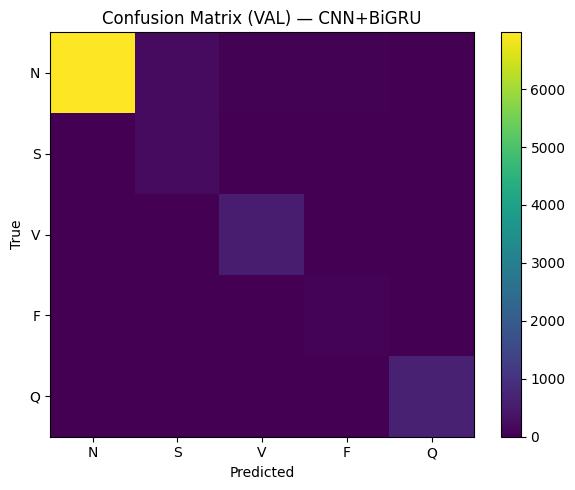

[VAL] PR-AUC(macro): 0.9620 | ROC-AUC(macro): 0.9980


In [21]:
# VAL evaluation — BiGRU

import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

proba_val_gru = model_gru.predict(ds_val, verbose=0)
y_val_pred_gru = proba_val_gru.argmax(axis=1)

print("[VAL BiGRU] macro-F1:", f1_score(y_val, y_val_pred_gru, average="macro"))
print(classification_report(y_val, y_val_pred_gru, target_names=["N","S","V","F","Q"], digits=4))

cm_val = confusion_matrix(y_val, y_val_pred_gru, labels=[0,1,2,3,4])
plt.figure(figsize=(6,5))
plt.imshow(cm_val, aspect='auto')
plt.title("Confusion Matrix (VAL) — CNN+BiGRU")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(5), ["N","S","V","F","Q"]); plt.yticks(range(5), ["N","S","V","F","Q"])
plt.colorbar(); plt.tight_layout(); plt.show()

try:
    ap_macro = average_precision_score(y_val, proba_val_gru, average="macro")
    roc_macro = roc_auc_score(y_val, proba_val_gru, multi_class="ovr", average="macro")
    print(f"[VAL] PR-AUC(macro): {ap_macro:.4f} | ROC-AUC(macro): {roc_macro:.4f}")
except Exception as e:
    print("AUC skipped:", e)


[TEST BiGRU] macro-F1: 0.8591815135550271
              precision    recall  f1-score   support

           N     0.9960    0.9645    0.9800     18118
           S     0.4917    0.9011    0.6362       556
           V     0.9299    0.9620    0.9457      1448
           F     0.6234    0.9198    0.7431       162
           Q     0.9962    0.9857    0.9909      1608

    accuracy                         0.9639     21892
   macro avg     0.8074    0.9466    0.8592     21892
weighted avg     0.9760    0.9639    0.9680     21892



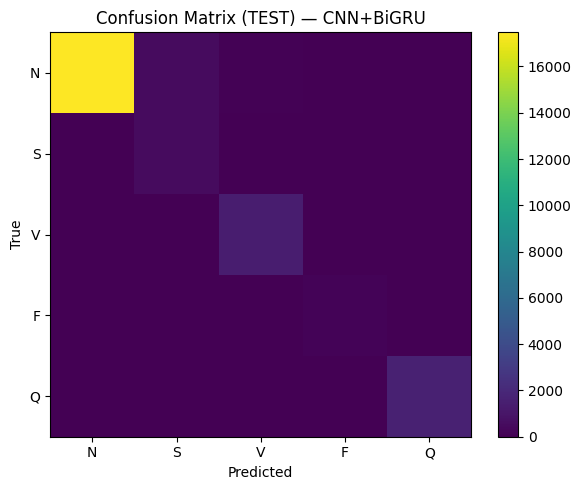

In [22]:
# TEST evaluation 

proba_test_gru = model_gru.predict(ds_test, verbose=0)
y_test_pred_gru = proba_test_gru.argmax(axis=1)

from sklearn.metrics import f1_score, classification_report, confusion_matrix
print("[TEST BiGRU] macro-F1:", f1_score(y_test, y_test_pred_gru, average="macro"))
print(classification_report(y_test, y_test_pred_gru, target_names=["N","S","V","F","Q"], digits=4))

cm_test = confusion_matrix(y_test, y_test_pred_gru, labels=[0,1,2,3,4])
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.imshow(cm_test, aspect='auto')
plt.title("Confusion Matrix (TEST) — CNN+BiGRU")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(5), ["N","S","V","F","Q"]); plt.yticks(range(5), ["N","S","V","F","Q"])
plt.colorbar(); plt.tight_layout(); plt.show()


In [24]:

import numpy as np, pandas as pd
from sklearn.metrics import f1_score

if 'proba_val_gru' not in globals():
    proba_val_gru = model_gru.predict(ds_val, verbose=0)

y_val_pred_arg = proba_val_gru.argmax(axis=1)
base_macro = f1_score(y_val, y_val_pred_arg, average="macro")
print(f"[VAL BiGRU] macro-F1 (argmax baseline): {base_macro:.4f}")

best_thr = np.full(5, 0.5)
best_macro = base_macro
grid = np.linspace(0.35, 0.75, 9)  

for c in range(5):
    for t in grid:
        thr_try = best_thr.copy()
        thr_try[c] = t
        yhat = np.argmax(proba_val_gru >= thr_try, axis=1)
        macro = f1_score(y_val, yhat, average="macro")
        if macro > best_macro:
            best_macro, best_thr[c] = macro, t

print("Best thresholds:", np.round(best_thr,3))
print("Best VAL macro-F1:", round(best_macro,4))


[VAL BiGRU] macro-F1 (argmax baseline): 0.8560
Best thresholds: [0.35 0.75 0.75 0.75 0.7 ]
Best VAL macro-F1: 0.8997


In [25]:
# Appling best thresholds to TEST, evaluate, and saving artifacts

import numpy as np, json, pandas as pd
from sklearn.metrics import f1_score, classification_report

# --- robust thresholded prediction ---
def predict_with_thresholds(P: np.ndarray, thr: np.ndarray) -> np.ndarray:
    """
    Vector-safe but simple: for each sample, if the top class prob < its threshold,
    try to pick the best class whose prob >= its threshold; else fall back to argmax.
    """
    y_arg = P.argmax(axis=1)
    y_out = y_arg.copy()
    for i in range(P.shape[0]):
        c = y_arg[i]
        if P[i, c] >= thr[c]:
            continue
        hits = np.where(P[i] >= thr)[0]
        if len(hits) == 0:
            # fallback: argmax
            y_out[i] = c
        elif len(hits) == 1:
            y_out[i] = hits[0]
        else:
            # among hits, choose the one with highest prob
            y_out[i] = hits[np.argmax(P[i, hits])]
    return y_out

assert 'proba_val_gru' in globals() and 'proba_test_gru' in globals()
assert 'best_thr' in globals()

# --- VAL comparison (sanity) ---
y_val_arg = proba_val_gru.argmax(axis=1)
y_val_thr = predict_with_thresholds(proba_val_gru, best_thr)
print(f"[VAL BiGRU] macro-F1 argmax: {f1_score(y_val, y_val_arg, average='macro'):.4f}")
print(f"[VAL BiGRU] macro-F1 thr   : {f1_score(y_val, y_val_thr, average='macro'):.4f}")

# --- TEST evaluation ---
y_test_arg = proba_test_gru.argmax(axis=1)
y_test_thr = predict_with_thresholds(proba_test_gru, best_thr)

macro_test_arg = f1_score(y_test, y_test_arg, average="macro")
macro_test_thr = f1_score(y_test, y_test_thr, average="macro")

print(f"\n[TEST BiGRU] macro-F1 argmax: {macro_test_arg:.4f}")
print(f"[TEST BiGRU] macro-F1 thr   : {macro_test_thr:.4f}\n")

print("[TEST BiGRU] report (thresholded):")
print(classification_report(y_test, y_test_thr, target_names=["N","S","V","F","Q"], digits=4))

# Saving thresholds & predictions
(RESULTS).mkdir(parents=True, exist_ok=True)
with open(RESULTS / "bigru_thresholds.json", "w") as f:
    json.dump({"thresholds": [float(x) for x in best_thr]}, f, indent=2)

pd.DataFrame({
    "y_true": y_test,
    "y_pred_argmax": y_test_arg,
    "y_pred_thr": y_test_thr
}).to_csv(RESULTS / "bigru_test_preds_argmax_vs_thr.csv", index=False)

print("Saved:", RESULTS / "bigru_thresholds.json")
print("Saved:", RESULTS / "bigru_test_preds_argmax_vs_thr.csv")


[VAL BiGRU] macro-F1 argmax: 0.8560
[VAL BiGRU] macro-F1 thr   : 0.8817

[TEST BiGRU] macro-F1 argmax: 0.8592
[TEST BiGRU] macro-F1 thr   : 0.8767

[TEST BiGRU] report (thresholded):
              precision    recall  f1-score   support

           N     0.9953    0.9727    0.9839     18118
           S     0.5557    0.8885    0.6837       556
           V     0.9379    0.9599    0.9488      1448
           F     0.6712    0.9198    0.7760       162
           Q     0.9962    0.9857    0.9909      1608

    accuracy                         0.9703     21892
   macro avg     0.8313    0.9453    0.8767     21892
weighted avg     0.9780    0.9703    0.9729     21892

Saved: C:\Users\nikhi\Music\ECG\results\bigru_thresholds.json
Saved: C:\Users\nikhi\Music\ECG\results\bigru_test_preds_argmax_vs_thr.csv


In [28]:
# DL leaderboard — BiLSTM vs BiGRU (argmax vs thresholded)

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score

# BiLSTM TEST preds
try:
    y_test_pred_bilstm = y_test_pred
except NameError:
    from tensorflow.keras.models import load_model
    bilstm_best = MODELS / "ecg_cnn_bilstm_best.keras"
    mdl_bilstm = load_model(bilstm_best)
    proba_test_bilstm = mdl_bilstm.predict(ds_test, verbose=0)
    y_test_pred_bilstm = proba_test_bilstm.argmax(axis=1)

# BiGRU TEST argmax preds 
try:
    y_test_arg = y_test_pred_gru 
except NameError:
    try:
        y_test_arg = proba_test_gru.argmax(axis=1)
    except NameError:
        from tensorflow.keras.models import load_model
        bigru_best = ckpt_gru_macro if 'ckpt_gru_macro' in globals() else (MODELS / "ecg_cnn_bigru_best_by_macroF1.keras")
        mdl_gru = load_model(bigru_best)
        proba_test_gru = mdl_gru.predict(ds_test, verbose=0)
        y_test_arg = proba_test_gru.argmax(axis=1)

# BiGRU TEST thresholded preds (from Cell 20); if missing, compute using best_thr
def predict_with_thresholds(P: np.ndarray, thr: np.ndarray) -> np.ndarray:
    y_arg = P.argmax(axis=1)
    y_out = y_arg.copy()
    for i in range(P.shape[0]):
        c = y_arg[i]
        if P[i, c] >= thr[c]:
            continue
        hits = np.where(P[i] >= thr)[0]
        if len(hits) == 0:
            y_out[i] = c
        elif len(hits) == 1:
            y_out[i] = hits[0]
        else:
            y_out[i] = hits[np.argmax(P[i, hits])]
    return y_out

try:
    y_test_thr = y_test_thr 
except NameError:
    assert 'proba_test_gru' in globals(), "proba_test_gru not found; rerun Cell 17/20."
    assert 'best_thr' in globals(), "best_thr not found; rerun Cell 19."
    y_test_thr = predict_with_thresholds(proba_test_gru, best_thr)

# --- Build leaderboard ---
# Cell 21 (final clean version): Full per-class leaderboard

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

def per_class_f1(y_true, y_pred):
    return [
        f1_score((y_true==c).astype(int), (y_pred==c).astype(int), zero_division=0)
        for c in range(5)
    ]

rows = []

# BiLSTM
rows.append({
    "model": "CNN+BiLSTM (argmax)",
    "test_macro_f1": f1_score(y_test, y_test_pred_bilstm, average="macro"),
    "test_f1_N": per_class_f1(y_test, y_test_pred_bilstm)[0],
    "test_f1_S": per_class_f1(y_test, y_test_pred_bilstm)[1],
    "test_f1_V": per_class_f1(y_test, y_test_pred_bilstm)[2],
    "test_f1_F": per_class_f1(y_test, y_test_pred_bilstm)[3],
    "test_f1_Q": per_class_f1(y_test, y_test_pred_bilstm)[4],
})

# BiGRU (argmax)
rows.append({
    "model": "CNN+BiGRU (argmax)",
    "test_macro_f1": f1_score(y_test, y_test_arg, average="macro"),
    "test_f1_N": per_class_f1(y_test, y_test_arg)[0],
    "test_f1_S": per_class_f1(y_test, y_test_arg)[1],
    "test_f1_V": per_class_f1(y_test, y_test_arg)[2],
    "test_f1_F": per_class_f1(y_test, y_test_arg)[3],
    "test_f1_Q": per_class_f1(y_test, y_test_arg)[4],
})

# BiGRU (thresholded)
rows.append({
    "model": "CNN+BiGRU (thresholded)",
    "test_macro_f1": f1_score(y_test, y_test_thr, average="macro"),
    "test_f1_N": per_class_f1(y_test, y_test_thr)[0],
    "test_f1_S": per_class_f1(y_test, y_test_thr)[1],
    "test_f1_V": per_class_f1(y_test, y_test_thr)[2],
    "test_f1_F": per_class_f1(y_test, y_test_thr)[3],
    "test_f1_Q": per_class_f1(y_test, y_test_thr)[4],
})

df_full = pd.DataFrame(rows).sort_values("test_macro_f1", ascending=False, ignore_index=True)

print("\n==== Full Per-Class Leaderboard (for analysis/report) ====\n")
display(df_full.round(4))

out_csv = RESULTS / "leaderboard_bilstm_vs_bigru_thr.csv"
df_full.round(4).to_csv(out_csv, index=False)
print("Saved:", out_csv)



==== Full Per-Class Leaderboard (for analysis/report) ====



,model,test_macro_f1,test_f1_N,test_f1_S,test_f1_V,test_f1_F,test_f1_Q
0,CNN+BiLSTM (argmax),0.9159,0.9920,0.8441,0.9590,0.7901,0.9944
1,CNN+BiGRU (thresholded),0.8767,0.9839,0.6837,0.9488,0.7760,0.9909
2,CNN+BiGRU (argmax),0.8592,0.9800,0.6362,0.9457,0.7431,0.9909


Saved: C:\Users\nikhi\Music\ECG\results\leaderboard_bilstm_vs_bigru_thr.csv


In [29]:
# SE block, Residual 1D block (with dilation), and temporal pooling helpers

from tensorflow.keras import layers
import tensorflow as tf

def se_block(x, reduction=8, name=None):
    """1D Squeeze-and-Excitation: per-channel reweighting."""
    ch = x.shape[-1]
    s = layers.GlobalAveragePooling1D(name=None if not name else name+"_gap")(x)
    s = layers.Dense(max(ch // reduction, 4), activation="relu",
                     name=None if not name else name+"_fc1")(s)
    s = layers.Dense(ch, activation="sigmoid",
                     name=None if not name else name+"_fc2")(s)
    s = layers.Reshape((1, ch))(s)
    return layers.Multiply(name=None if not name else name+"_scale")([x, s])

def conv1d_bn(x, filters, kernel_size, stride=1, dilation=1, name=None):
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding="same",
                      dilation_rate=dilation, use_bias=False,
                      name=None if not name else name+"_conv")(x)
    x = layers.BatchNormalization(name=None if not name else name+"_bn")(x)
    x = layers.Activation("relu", name=None if not name else name+"_relu")(x)
    return x

def resblock_1d(x, filters, kernel_size=5, dilation=1, name=None):
    """Residual 1D block: Conv-BN-ReLU → Conv-BN + SE → Add → ReLU."""
    shortcut = x
    x = conv1d_bn(x, filters, kernel_size, dilation=dilation, name=None if not name else name+"_a")
    x = layers.Conv1D(filters, kernel_size, padding="same", dilation_rate=dilation,
                      use_bias=False, name=None if not name else name+"_b_conv")(x)
    x = layers.BatchNormalization(name=None if not name else name+"_b_bn")(x)
    x = se_block(x, reduction=8, name=None if not name else name+"_se")
    # match channels if needed
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, padding="same", use_bias=False,
                                 name=None if not name else name+"_proj")(shortcut)
        shortcut = layers.BatchNormalization(name=None if not name else name+"_proj_bn")(shortcut)
    x = layers.Add(name=None if not name else name+"_add")([x, shortcut])
    x = layers.Activation("relu", name=None if not name else name+"_out")(x)
    return x

def temporal_pool_concat(x, use_std=True, name="tpool"):
    """Temporal pooling: GlobalAvg + GlobalMax (+ GlobalStd) → concat."""
    avg = layers.GlobalAveragePooling1D(name=name+"_avg")(x)
    mx  = layers.GlobalMaxPooling1D(name=name+"_max")(x)
    parts = [avg, mx]
    if use_std:
        mean = layers.GlobalAveragePooling1D(name=name+"_mean")(x)
        mean_sq = layers.GlobalAveragePooling1D(name=name+"_mean_sq")(layers.Multiply()([x, x]))
        std = layers.Lambda(lambda z: tf.sqrt(tf.maximum(z[0] - tf.square(z[1]), 1e-8)),
                            name=name+"_std")([mean_sq, mean])
        parts.append(std)
    return layers.Concatenate(name=name+"_concat")(parts)


In [30]:
# Build CNN (Res+SE+Dil) + Stacked BiLSTM (residual) + Avg/Max/Std pooling

from tensorflow.keras import Model, layers

def build_cnn_bilstm_res_se(input_len=187, channels=1, n_classes=5,
                            base=48, lstm_units=64,
                            stem_dropout=0.15, head_dropout=0.20):
    inp = layers.Input(shape=(input_len, channels))

    # --- CNN stem: mild downsampling, residual blocks with light dilation
    x = conv1d_bn(inp, base, 15, stride=1, dilation=1, name="stem1")
    x = resblock_1d(x, base,   kernel_size=7, dilation=1, name="rb1")
    x = conv1d_bn(x,  base,    7,  stride=2, dilation=1, name="down1")    # /2

    x = resblock_1d(x, base*2, kernel_size=7, dilation=1, name="rb2")
    x = conv1d_bn(x,  base*2,  5,  stride=2, dilation=1, name="down2")    # /2

    x = resblock_1d(x, base*4, kernel_size=3, dilation=2, name="rb3")     # small dilation widens RF
    x = layers.Dropout(stem_dropout, name="cnn_dropout")(x)

    # --- Stacked BiLSTM with residual skip
    x1 = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True), name="bilstm1")(x)
    x2 = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True), name="bilstm2")(x1)
    x = layers.Add(name="bilstm_residual")([x1, x2])  # better gradient flow

    # --- Temporal pooling (Avg + Max + Std)
    x = temporal_pool_concat(x, use_std=True, name="tpool")

    # --- Classifier head
    x = layers.Dropout(head_dropout, name="head_dropout")(x)
    out = layers.Dense(n_classes, activation="softmax", dtype="float32", name="output")(x)

    return Model(inp, out, name="CNN_ResSE_StackedBiLSTM")

model_res_se = build_cnn_bilstm_res_se(INPUT_LEN, CHANNELS, NUM_CLASSES,
                                       base=48, lstm_units=64,
                                       stem_dropout=0.15, head_dropout=0.20)
model_res_se.summary()


Model: "CNN_ResSE_StackedBiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 187, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem1_conv (Conv1D)           │ (None, 187, 48)           │             720 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem1_bn (BatchNormalization) │ (None, 187, 48)           │             192 │ stem1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem1_relu (Activation)       │ (None, 187, 48)           │               0 │ stem1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rb1_a_conv (Conv1D)           │ (None, 187, 48)           │          16,128 │ stem1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rb1_a_bn (BatchNormalization) │ (None, 187, 48)           │             192 │ rb1_a_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rb1_a_relu (Activation)       │ (None, 187, 48)           │               0 │ rb1_a_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rb1_b_conv (Conv1D)           │ (None, 187, 48)           │          16,128 │ rb1_a_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rb1_b_bn (BatchNormalization) │ (None, 187, 48)           │             192 │ rb1_b_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rb1_se_gap                    │ (None, 48)                │               0 │ rb1_b_bn[0][0]             │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rb1_se_fc1 (Dense)            │ (None, 6)                 │             294 │ rb1_se_gap[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rb1_se_fc2 (Dense)            │ (None, 48)                │             336 │ rb1_se_fc1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 48)             │               0 │ rb1_se_fc2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rb1_se_scale (Multiply)       │ (None, 187, 48)           │               0 │ rb1_b_bn[0][0],            │
│                               │                           │                 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rb1_add (Add)                 │ (None, 187, 48)           │               0 │ rb1_se_scale[0][0],        │
│                               │                           │                 │ stem1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rb1_out (Activation)          │ (None, 187, 48)           │               

 Total params: 630,287 (2.40 MB)

 Trainable params: 627,983 (2.40 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [31]:
# Compile + macro-F1 early stopping for Res+SE+StackedBiLSTM

from tensorflow import keras
import numpy as np
from sklearn.metrics import f1_score

LR = 1e-3
model_res_se.compile(
    optimizer=keras.optimizers.Adam(LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

class ValMacroF1(keras.callbacks.Callback):
    def __init__(self, ds_val, patience=8, ckpt_path=None, verbose=1):
        super().__init__()
        self.ds_val = ds_val
        self.patience = patience
        self.ckpt_path = ckpt_path
        self.verbose = verbose
        self.best = -np.inf
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        P = self.model.predict(self.ds_val, verbose=0)
        y_pred = P.argmax(axis=1)
        macro = f1_score(y_val, y_pred, average="macro")
        if self.verbose:
            print(f"\n[epoch {epoch+1}] val_macroF1={macro:.4f}")
        if macro > self.best + 1e-4:
            self.best = macro
            self.wait = 0
            if self.ckpt_path is not None:
                self.model.save(self.ckpt_path)
                if self.verbose:
                    print(f"[ValMacroF1] ↑ New best saved → {self.ckpt_path}")
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose:
                    print(f"[ValMacroF1] Early stopping on macro-F1.")
                self.model.stop_training = True

ckpt_res_se = MODELS / "ecg_cnn_resse_stackedbilstm_best_by_macroF1.keras"
callbacks_res_se = [
    ValMacroF1(ds_val, patience=8, ckpt_path=ckpt_res_se.as_posix(), verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]
print("Macro-F1 checkpoint:", ckpt_res_se)


Macro-F1 checkpoint: C:\Users\nikhi\Music\ECG\models\ecg_cnn_resse_stackedbilstm_best_by_macroF1.keras


In [32]:
# Train CNN_ResSE_StackedBiLSTM

EPOCHS = 35
history_res_se = model_res_se.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks_res_se,
    verbose=1
)


Epoch 1/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - acc: 0.6203 - loss: 0.7509
[epoch 1] val_macroF1=0.4429
[ValMacroF1] ↑ New best saved → C:/Users/nikhi/Music/ECG/models/ecg_cnn_resse_stackedbilstm_best_by_macroF1.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - acc: 0.7280 - loss: 0.5349 - val_acc: 0.6052 - val_loss: 1.0983 - learning_rate: 0.0010
Epoch 2/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - acc: 0.8420 - loss: 0.3307
[epoch 2] val_macroF1=0.8039
[ValMacroF1] ↑ New best saved → C:/Users/nikhi/Music/ECG/models/ecg_cnn_resse_stackedbilstm_best_by_macroF1.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 300s 958ms/step - acc: 0.8500 - loss: 0.3103 - val_acc: 0.9470 - val_loss: 0.1663 - learning_rate: 0.0010
Epoch 3/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - acc: 0.8692 - loss: 0.2652
[epoch 3] val_macroF1=0.6699
313/313 ━━━━━━━━━━━━━━━━━━━━ 314s 932ms/step - acc: 0.8758 - loss: 0.2547 - val_acc: 0.8645 - val_loss: 0.3527 - learning_rate: 0.0010
Epoch 4/35
313/313 ━━━━━━━━━━━━━━━

In [33]:
# Evaluate & save; leaderboard vs BiLSTM champion

import numpy as np, pandas as pd
from sklearn.metrics import f1_score, classification_report

# VAL
proba_val_res = model_res_se.predict(ds_val, verbose=0)
y_val_pred_res = proba_val_res.argmax(axis=1)
val_macro_res = f1_score(y_val, y_val_pred_res, average="macro")
print("[VAL ResSE+StackedBiLSTM] macro-F1:", round(val_macro_res, 4))
print(classification_report(y_val, y_val_pred_res, target_names=["N","S","V","F","Q"], digits=4))

# TEST
proba_test_res = model_res_se.predict(ds_test, verbose=0)
y_test_pred_res = proba_test_res.argmax(axis=1)
test_macro_res = f1_score(y_test, y_test_pred_res, average="macro")
print("[TEST ResSE+StackedBiLSTM] macro-F1:", round(test_macro_res, 4))
print(classification_report(y_test, y_test_pred_res, target_names=["N","S","V","F","Q"], digits=4))

# Save artifacts
model_res_se.save(MODELS / "ecg_cnn_resse_stackedbilstm_last.keras")
np.save(RESULTS / "cnn_resse_stackedbilstm_val_pred.npy",  y_val_pred_res)
np.save(RESULTS / "cnn_resse_stackedbilstm_test_pred.npy", y_test_pred_res)

# Compare vs existing BiLSTM (argmax)
rows = []
rows.append({
    "model": "CNN+BiLSTM (argmax)",
    "test_macro_f1": f1_score(y_test, y_test_pred, average="macro"),
    "test_f1_S": f1_score((y_test==1).astype(int), (y_test_pred==1).astype(int), zero_division=0),
    "test_f1_F": f1_score((y_test==3).astype(int), (y_test_pred==3).astype(int), zero_division=0),
})
rows.append({
    "model": "CNN+ResSE+StackedBiLSTM",
    "test_macro_f1": test_macro_res,
    "test_f1_S": f1_score((y_test==1).astype(int), (y_test_pred_res==1).astype(int), zero_division=0),
    "test_f1_F": f1_score((y_test==3).astype(int), (y_test_pred_res==3).astype(int), zero_division=0),
})
df = pd.DataFrame(rows).sort_values("test_macro_f1", ascending=False, ignore_index=True)
display(df.round(4))
df.to_csv(RESULTS / "leaderboard_bilstm_resse_vs_base.csv", index=False)
print("Saved:", RESULTS / "leaderboard_bilstm_resse_vs_base.csv")


[VAL ResSE+StackedBiLSTM] macro-F1: 0.8913
              precision    recall  f1-score   support

           N     0.9964    0.9833    0.9898      7248
           S     0.8185    0.9144    0.8638       222
           V     0.9463    0.9741    0.9600       579
           F     0.5347    0.8438    0.6545        64
           Q     0.9772    1.0000    0.9885       643

    accuracy                         0.9812      8756
   macro avg     0.8546    0.9431    0.8913      8756
weighted avg     0.9838    0.9812    0.9821      8756

[TEST ResSE+StackedBiLSTM] macro-F1: 0.8919
              precision    recall  f1-score   support

           N     0.9949    0.9844    0.9896     18118
           S     0.7964    0.8723    0.8326       556
           V     0.9562    0.9655    0.9608      1448
           F     0.5577    0.8951    0.6872       162
           Q     0.9816    0.9969    0.9892      1608

    accuracy                         0.9806     21892
   macro avg     0.8574    0.9428    0.8919 

,model,test_macro_f1,test_f1_S,test_f1_F
0,CNN+BiLSTM (argmax),0.9159,0.8441,0.7901
1,CNN+ResSE+StackedBiLSTM,0.8919,0.8326,0.6872


Saved: C:\Users\nikhi\Music\ECG\results\leaderboard_bilstm_resse_vs_base.csv


In [36]:
# Focal-loss fine-tune starting from BEST WEIGHTS 

import numpy as np
import tensorflow as tf
from tensorflow import keras

# 1) Get a model instance with the same architecture
try:
    model_res_se_ft = model_res_se  # reuse current model in memory if defined
    print("Using in-memory model_res_se.")
except NameError:
    # Rebuild architecture exactly as you used in Cells 22–23
    # (Assumes build_cnn_bilstm_res_se is already defined in your notebook)
    model_res_se_ft = build_cnn_bilstm_res_se(INPUT_LEN, CHANNELS, NUM_CLASSES,
                                              base=48, lstm_units=64,
                                              stem_dropout=0.15, head_dropout=0.20)
    print("Rebuilt architecture: CNN_ResSE_StackedBiLSTM")

# 2) Load BEST WEIGHTS into this instance 
try:
    model_res_se_ft.load_weights(ckpt_res_se.as_posix())
    print("Loaded BEST weights from:", ckpt_res_se)
except Exception as e:
    print("WARNING: Could not load weights from best checkpoint:", e)
    print("Proceeding with current model weights.")

# 3) Focal loss (class-balanced alpha from your class_weight)
alpha_vec = np.array([class_weight[c] for c in range(5)], dtype=np.float32)
alpha_vec = alpha_vec / alpha_vec.mean()
GAMMA = 2.0

def sparse_categorical_focal_loss(alpha=None, gamma=2.0, eps=1e-7):
    alpha_t = None if alpha is None else tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        y_true_oh = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        pt = tf.reduce_sum(y_true_oh * y_pred, axis=-1)
        a = tf.reduce_sum(y_true_oh * alpha_t, axis=-1) if alpha_t is not None else 1.0
        return tf.reduce_mean(-a * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss_fn

model_res_se_ft.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=sparse_categorical_focal_loss(alpha=alpha_vec, gamma=GAMMA),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

# 4) Early stop on macro-F1 
ckpt_res_se_focal = MODELS / "ecg_cnn_resse_stackedbilstm_focal_best.keras"
callbacks_focal = [
    ValMacroF1(ds_val, patience=4, ckpt_path=ckpt_res_se_focal.as_posix(), verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]

history_focal = model_res_se_ft.fit(
    ds_train,
    validation_data=ds_val,
    epochs=8,           
    class_weight=None,  # focal handles reweighting
    callbacks=callbacks_focal,
    verbose=1
)


Using in-memory model_res_se.
Loaded BEST weights from: C:\Users\nikhi\Music\ECG\models\ecg_cnn_resse_stackedbilstm_best_by_macroF1.keras
Epoch 1/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9894 - loss: 0.0025
[epoch 1] val_macroF1=0.9221
[ValMacroF1] ↑ New best saved → C:/Users/nikhi/Music/ECG/models/ecg_cnn_resse_stackedbilstm_focal_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - acc: 0.9899 - loss: 0.0021 - val_acc: 0.9849 - val_loss: 0.0329 - learning_rate: 1.0000e-04
Epoch 2/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9888 - loss: 0.0022
[epoch 2] val_macroF1=0.9171
313/313 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - acc: 0.9880 - loss: 0.0022 - val_acc: 0.9858 - val_loss: 0.0305 - learning_rate: 1.0000e-04
Epoch 3/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - acc: 0.9900 - loss: 0.0019
[epoch 3] val_macroF1=0.9165
313/313 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - acc: 0.9894 - loss: 0.0018 - val_acc: 0.9848 - val_loss: 0.0298 - learning_rate: 1.0000e-04
Epoch 4/8
313/313 

In [37]:
# Evaluating focal-tuned model vs pre-finetune (VAL & TEST)

import numpy as np
from pathlib import Path
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.models import load_model

def build_fresh_model():
    return build_cnn_bilstm_res_se(
        INPUT_LEN, CHANNELS, NUM_CLASSES,
        base=48, lstm_units=64,
        stem_dropout=0.15, head_dropout=0.20
    )

def safe_load_full_or_weights(model_path: Path):
    try:
        mdl = load_model(model_path, safe_mode=False)
        print("Loaded full model:", model_path)
        return mdl
    except Exception as e:
        print("Full model load failed; falling back to weights:", e)
        mdl = build_fresh_model()
        mdl.load_weights(model_path.as_posix())
        print("Loaded weights into fresh model:", model_path)
        return mdl

# ---------- 1) Pre-finetune predictions (if not already available) ----------

have_pre = ('proba_val_res' in globals()) and ('proba_test_res' in globals())
if not have_pre:
    # Load pre-finetune best weights and run inference
    print("Computing pre-finetune predictions from best pre-focal checkpoint…")
    mdl_pre = build_fresh_model()
    try:
        mdl_pre.load_weights(ckpt_res_se.as_posix())
        print("Loaded pre-finetune BEST weights from:", ckpt_res_se)
    except Exception as e:
        print("WARNING: Could not load pre-finetune weights:", e)
        print("Proceeding with current model (may be slightly off).")
    proba_val_res  = mdl_pre.predict(ds_val,  verbose=0)
    proba_test_res = mdl_pre.predict(ds_test, verbose=0)

y_val_pred_pre  = proba_val_res.argmax(axis=1)
y_test_pred_pre = proba_test_res.argmax(axis=1)
val_macro_pre   = f1_score(y_val,  y_val_pred_pre,  average="macro")
test_macro_pre  = f1_score(y_test, y_test_pred_pre, average="macro")

# ---------- 2) Load focal-tuned model (best) and predict ----------

print("\nLoading focal-tuned BEST checkpoint for evaluation…")
mdl_post = safe_load_full_or_weights(ckpt_res_se_focal)

proba_val_post  = mdl_post.predict(ds_val,  verbose=0)
proba_test_post = mdl_post.predict(ds_test, verbose=0)

y_val_pred_post  = proba_val_post.argmax(axis=1)
y_test_pred_post = proba_test_post.argmax(axis=1)

val_macro_post  = f1_score(y_val,  y_val_pred_post,  average="macro")
test_macro_post = f1_score(y_test, y_test_pred_post, average="macro")

# ---------- 3) Report ----------

print(f"\n[VAL]  macro-F1: pre={val_macro_pre:.4f}  → post={val_macro_post:.4f}")
print(f"[TEST] macro-F1: pre={test_macro_pre:.4f} → post={test_macro_post:.4f}\n")

print("[TEST] report (post-focal):")
print(classification_report(y_test, y_test_pred_post, target_names=["N","S","V","F","Q"], digits=4))

# ---------- 4) Keep arrays in globals  ----------

proba_val_pre   = proba_val_res
proba_test_pre  = proba_test_res
proba_val_post  = proba_val_post
proba_test_post = proba_test_post



Loading focal-tuned BEST checkpoint for evaluation…
Full model load failed; falling back to weights: Exception encountered when calling Lambda.call().

We could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.

Arguments received by Lambda.call():
  • args=(['<KerasTensor shape=(None, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_447>', '<KerasTensor shape=(None, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_449>'],)
  • kwargs={'mask': ['None', 'None']}
Loaded weights into fresh model: C:\Users\nikhi\Music\ECG\models\ecg_cnn_resse_stackedbilstm_focal_best.keras

[VAL]  macro-F1: pre=0.8913  → post=0.9259
[TEST] macro-F1: pre=0.8919 → post=0.9219

[TEST] report (post-focal):
              precision    recall  f1-score   support

           N     0.9939    0.9918    0.9928     18118
           S     0.8336    0.8561    0.8447       556
           V     0.9593    0.9606  

In [38]:
# Threshold tuning (coordinate search) for focal-tuned model

import numpy as np
from sklearn.metrics import f1_score

if 'proba_val_post' not in globals() or 'proba_test_post' not in globals():
    try:
        mdl_tmp = build_cnn_bilstm_res_se(INPUT_LEN, CHANNELS, NUM_CLASSES,
                                          base=48, lstm_units=64,
                                          stem_dropout=0.15, head_dropout=0.20)
        mdl_tmp.load_weights(ckpt_res_se_focal.as_posix())
        proba_val_post  = mdl_tmp.predict(ds_val,  verbose=0)
        proba_test_post = mdl_tmp.predict(ds_test, verbose=0)
        print("Recomputed proba_val_post/proba_test_post from focal-best weights.")
    except Exception as e:
        raise RuntimeError("Could not recover proba_val_post/proba_test_post. "
                           "Please re-run 27A and 27B first.") from e

# --- Argmax baseline on VAL ---
y_val_arg = proba_val_post.argmax(axis=1)
base_macro = f1_score(y_val, y_val_arg, average="macro")
print(f"[VAL focal] macro-F1 (argmax baseline): {base_macro:.4f}")

# --- Threshold search (coordinate-wise) ---
def predict_with_thresholds(P, thr):
    y_arg = P.argmax(axis=1)
    out = y_arg.copy()
    for i in range(P.shape[0]):
        c = y_arg[i]
        if P[i, c] >= thr[c]:
            continue
        hits = np.where(P[i] >= thr)[0]
        if hits.size == 0:
            out[i] = c
        elif hits.size == 1:
            out[i] = hits[0]
        else:
            out[i] = hits[np.argmax(P[i, hits])]
    return out

grid = np.linspace(0.35, 0.80, 10)    # coarse but effective; we will widen if needed
best_thr = np.full(5, 0.50, dtype=float)
best_macro = base_macro

for cls in range(5):
    for t in grid:
        thr_try = best_thr.copy()
        thr_try[cls] = t
        yhat = predict_with_thresholds(proba_val_post, thr_try)
        macro = f1_score(y_val, yhat, average="macro")
        if macro > best_macro:
            best_macro = macro
            best_thr = thr_try

print("Best VAL macro-F1 (thresholded):", round(best_macro, 4))
print("Best thresholds:", np.round(best_thr, 3))


[VAL focal] macro-F1 (argmax baseline): 0.9259
Best VAL macro-F1 (thresholded): 0.9321
Best thresholds: [0.35 0.65 0.5  0.65 0.5 ]


In [39]:
# Apply thresholds → TEST; compare & save

import json, pandas as pd
from sklearn.metrics import f1_score, classification_report

assert 'best_thr' in globals(), "Run Cell 27C first to compute best_thr."

y_val_arg = proba_val_post.argmax(axis=1)
y_val_thr = predict_with_thresholds(proba_val_post, best_thr)
print(f"[VAL focal] macro-F1 argmax: {f1_score(y_val, y_val_arg, average='macro'):.4f}")
print(f"[VAL focal] macro-F1 thr   : {f1_score(y_val, y_val_thr, average='macro'):.4f}")

# TEST: argmax vs thresholded
y_test_arg = proba_test_post.argmax(axis=1)
y_test_thr = predict_with_thresholds(proba_test_post, best_thr)

macro_test_arg = f1_score(y_test, y_test_arg, average="macro")
macro_test_thr = f1_score(y_test, y_test_thr, average="macro")

print(f"\n[TEST focal] macro-F1 argmax: {macro_test_arg:.4f}")
print(f"[TEST focal] macro-F1  thr  : {macro_test_thr:.4f}\n")

print("[TEST focal] report (thresholded):")
print(classification_report(y_test, y_test_thr, target_names=["N","S","V","F","Q"], digits=4))

# Save thresholds & predictions
with open(RESULTS / "resse_bilstm_focal_thresholds.json", "w") as f:
    json.dump({"thresholds": [float(x) for x in best_thr]}, f, indent=2)

pd.DataFrame({
    "y_true": y_test,
    "y_pred_argmax": y_test_arg,
    "y_pred_thr": y_test_thr
}).to_csv(RESULTS / "resse_bilstm_focal_test_preds_argmax_vs_thr.csv", index=False)

print("Saved:", RESULTS / "resse_bilstm_focal_thresholds.json")
print("Saved:", RESULTS / "resse_bilstm_focal_test_preds_argmax_vs_thr.csv")


[VAL focal] macro-F1 argmax: 0.9259
[VAL focal] macro-F1 thr   : 0.9321

[TEST focal] macro-F1 argmax: 0.9219
[TEST focal] macro-F1  thr  : 0.9265

[TEST focal] report (thresholded):
              precision    recall  f1-score   support

           N     0.9932    0.9935    0.9934     18118
           S     0.8648    0.8399    0.8522       556
           V     0.9606    0.9599    0.9603      1448
           F     0.8000    0.8642    0.8309       162
           Q     0.9963    0.9950    0.9956      1608

    accuracy                         0.9866     21892
   macro avg     0.9230    0.9305    0.9265     21892
weighted avg     0.9866    0.9866    0.9866     21892

Saved: C:\Users\nikhi\Music\ECG\results\resse_bilstm_focal_thresholds.json
Saved: C:\Users\nikhi\Music\ECG\results\resse_bilstm_focal_test_preds_argmax_vs_thr.csv


In [40]:
# Save final focal-tuned weights and a reusable predictor

import json
import numpy as np
from pathlib import Path
from tensorflow.keras.models import load_model

final_model = build_cnn_bilstm_res_se(INPUT_LEN, CHANNELS, NUM_CLASSES,
                                      base=48, lstm_units=64,
                                      stem_dropout=0.15, head_dropout=0.20)
final_model.load_weights(ckpt_res_se_focal.as_posix())
print("Loaded focal-best weights:", ckpt_res_se_focal)

final_weights_path = MODELS / "ecg_cnn_resse_stackedbilstm_focal_best.weights.h5"
final_model.save_weights(final_weights_path.as_posix())
print("Saved final weights:", final_weights_path)

thr_path = RESULTS / "resse_bilstm_focal_thresholds.json"
with open(thr_path, "r") as f:
    best_thr = np.array(json.load(f)["thresholds"], dtype=float)
print("Loaded thresholds:", best_thr)

def predict_with_thresholds(P, thr):
    y_arg = P.argmax(axis=1)
    out = y_arg.copy()
    for i in range(P.shape[0]):
        c = y_arg[i]
        if P[i, c] >= thr[c]:
            continue
        hits = np.where(P[i] >= thr)[0]
        if hits.size == 0:
            out[i] = c
        elif hits.size == 1:
            out[i] = hits[0]
        else:
            out[i] = hits[np.argmax(P[i, hits])]
    return out

def predict_heartbeat(batch_ecg_187x1, model, thr):
    """
    batch_ecg_187x1: np.ndarray of shape (B, 187, 1), z-score normalized per beat (same as training).
    Returns: (pred_labels, pred_proba)
    """
    proba = model.predict(batch_ecg_187x1, verbose=0)
    labels = predict_with_thresholds(proba, thr)
    return labels, proba

print("Predictor ready: call predict_heartbeat(X, final_model, best_thr).")


Loaded focal-best weights: C:\Users\nikhi\Music\ECG\models\ecg_cnn_resse_stackedbilstm_focal_best.keras
Saved final weights: C:\Users\nikhi\Music\ECG\models\ecg_cnn_resse_stackedbilstm_focal_best.weights.h5
Loaded thresholds: [0.35 0.65 0.5  0.65 0.5 ]
Predictor ready: call predict_heartbeat(X, final_model, best_thr).


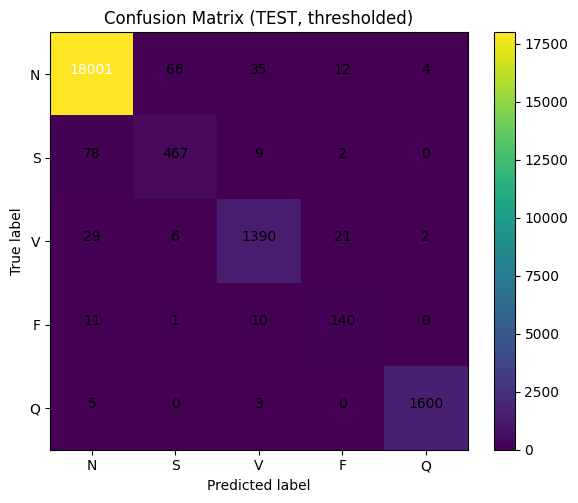

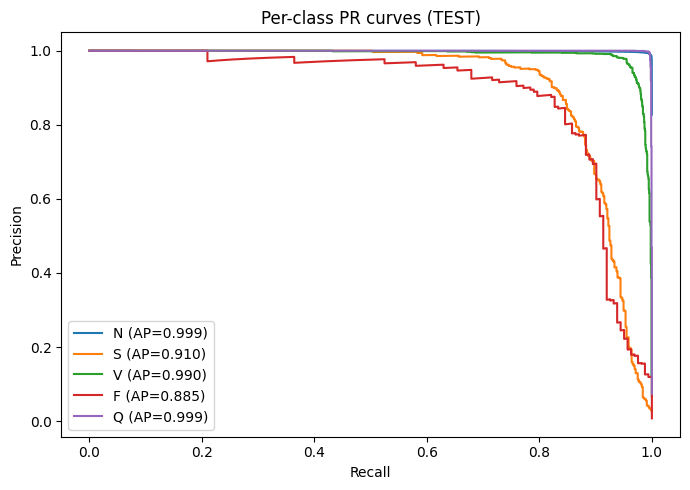

Saved plots to: C:\Users\nikhi\Music\ECG\results


In [41]:
# Confusion matrix & PR curves (TEST), saved to /results

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
import itertools

P_test = proba_test_post
y_true = y_test
y_pred_thr = predict_with_thresholds(P_test, best_thr)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_thr, labels=[0,1,2,3,4])
classes = ["N","S","V","F","Q"]

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (TEST, thresholded)')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes); plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(RESULTS / "final_confusion_matrix_test.png", dpi=150)
plt.show()

# Per-class PR curves
plt.figure(figsize=(7,5))
aps = []
for c in range(5):
    y_true_bin = (y_true==c).astype(int)
    prec, rec, _ = precision_recall_curve(y_true_bin, P_test[:, c])
    ap = average_precision_score(y_true_bin, P_test[:, c])
    aps.append(ap)
    plt.plot(rec, prec, label=f"{classes[c]} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Per-class PR curves (TEST)")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS / "final_pr_curves_test.png", dpi=150)
plt.show()

print("Saved plots to:", RESULTS)


In [44]:
# Final Leaderboard 

import numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score

ROWS = []
RESULTS = Path("C:/Users/nikhi/Music/ECG/results")
assert 'y_test' in globals(), "y_test not found."

def add_row(name, y_pred, y_true):
    macro = f1_score(y_true, y_pred, average="macro")
    per = [f1_score((y_true==c).astype(int), (y_pred==c).astype(int), zero_division=0) for c in range(5)]
    ROWS.append({
        "model": name,
        "test_macro_f1": macro,
        "test_f1_N": per[0], "test_f1_S": per[1],
        "test_f1_V": per[2], "test_f1_F": per[3], "test_f1_Q": per[4],
    })

# ---------- 1) ResSE + Stacked BiLSTM + FOCAL (post) ----------
added_any = False
try:
    if 'proba_test_post' in globals() and 'best_thr' in globals():
        # Use the same thresholding function as earlier cells
        def _predict_with_thresholds(P, thr):
            y_arg = P.argmax(axis=1); out = y_arg.copy()
            for i in range(P.shape[0]):
                c = y_arg[i]
                if P[i, c] >= thr[c]:  # confident argmax
                    continue
                hits = np.where(P[i] >= thr)[0]
                if hits.size == 0: out[i] = c
                elif hits.size == 1: out[i] = hits[0]
                else: out[i] = hits[np.argmax(P[i, hits])]
            return out
        y_pred_thr = _predict_with_thresholds(proba_test_post, best_thr)
        add_row("ResSE+StackedBiLSTM + Focal (thresholded)", y_pred_thr, y_test)
        # also record argmax for completeness
        add_row("ResSE+StackedBiLSTM + Focal (argmax)", proba_test_post.argmax(axis=1), y_test)
        added_any = True
    else:
        p = RESULTS / "resse_bilstm_focal_test_preds_argmax_vs_thr.csv"
        if p.exists():
            df = pd.read_csv(p)
            if {'y_true','y_pred_thr'}.issubset(df.columns):
                add_row("ResSE+StackedBiLSTM + Focal (thresholded)",
                        df['y_pred_thr'].astype(int).to_numpy(),
                        df['y_true'].astype(int).to_numpy())
                if 'y_pred_argmax' in df.columns:
                    add_row("ResSE+StackedBiLSTM + Focal (argmax)",
                            df['y_pred_argmax'].astype(int).to_numpy(),
                            df['y_true'].astype(int).to_numpy())
                added_any = True
except Exception as e:
    print("Skip ResSE+BiLSTM + Focal:", e)

# ---------- 2) ResSE + Stacked BiLSTM (pre-focal, argmax) ----------
try:
    if 'y_test_pred_res' in globals():
        add_row("ResSE+StackedBiLSTM (pre-focal, argmax)", y_test_pred_res, y_test)
        added_any = True
    else:
        npy_pred = RESULTS / "cnn_resse_stackedbilstm_test_pred.npy"
        if npy_pred.exists():
            add_row("ResSE+StackedBiLSTM (pre-focal, argmax)", np.load(npy_pred), y_test)
            added_any = True
except Exception as e:
    print("Skip ResSE+StackedBiLSTM (pre-focal):", e)

# ---------- 3) CNN + BiLSTM (baseline, argmax) ----------
try:
    if 'y_test_pred' in globals():
        add_row("CNN+BiLSTM (argmax)", y_test_pred, y_test)
        added_any = True
    else:
        # if you saved it earlier (optional): RESULTS / "cnn_bilstm_test_pred.npy"
        npy_pred = RESULTS / "cnn_bilstm_test_pred.npy"
        if npy_pred.exists():
            add_row("CNN+BiLSTM (argmax)", np.load(npy_pred), y_test)
            added_any = True
except Exception as e:
    print("Skip CNN+BiLSTM (argmax):", e)

# ---------- 4) CNN + BiGRU (thresholded & argmax) ----------
try:
    p = RESULTS / "bigru_test_preds_argmax_vs_thr.csv"
    if p.exists():
        df = pd.read_csv(p)
        if {'y_true','y_pred_thr'}.issubset(df.columns):
            add_row("CNN+BiGRU (thresholded)", df['y_pred_thr'].astype(int).to_numpy(),
                                            df['y_true'].astype(int).to_numpy())
            added_any = True
        if {'y_true','y_pred_argmax'}.issubset(df.columns):
            add_row("CNN+BiGRU (argmax)", df['y_pred_argmax'].astype(int).to_numpy(),
                                         df['y_true'].astype(int).to_numpy())
            added_any = True
except Exception as e:
    print("Skip CNN+BiGRU variants:", e)

if not added_any:
    raise RuntimeError("No DL artifacts found. Ensure earlier evaluation cells wrote predictions to memory/RESULTS.")

# ---------- Final tables ----------
leaderboard = pd.DataFrame(ROWS).sort_values("test_macro_f1", ascending=False, ignore_index=True)
display(leaderboard.round(4))

# Save
out_csv_full = RESULTS / "final_dl_leaderboard_full.csv"
leaderboard.to_csv(out_csv_full, index=False)
print("Saved:", out_csv_full)

out_csv_compact = RESULTS / "final_dl_leaderboard_compact.csv"
compact.to_csv(out_csv_compact, index=False)
print("Saved:", out_csv_compact)


,model,test_macro_f1,test_f1_N,test_f1_S,test_f1_V,test_f1_F,test_f1_Q
0,ResSE+StackedBiLSTM + Focal (thresholded),0.9265,0.9934,0.8522,0.9603,0.8309,0.9956
1,ResSE+StackedBiLSTM + Focal (argmax),0.9219,0.9928,0.8447,0.9600,0.8161,0.9956
2,CNN+BiLSTM (argmax),0.9159,0.9920,0.8441,0.9590,0.7901,0.9944
3,"ResSE+StackedBiLSTM (pre-focal, argmax)",0.8919,0.9896,0.8326,0.9608,0.6872,0.9892
4,CNN+BiGRU (thresholded),0.8767,0.9839,0.6837,0.9488,0.7760,0.9909
5,CNN+BiGRU (argmax),0.8592,0.9800,0.6362,0.9457,0.7431,0.9909


Saved: C:\Users\nikhi\Music\ECG\results\final_dl_leaderboard_full.csv
Saved: C:\Users\nikhi\Music\ECG\results\final_dl_leaderboard_compact.csv
